In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import random

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2

In [2]:
np.random.seed(0)

In [3]:
df_orig = pd.read_csv('../wf_df_raw.csv')

In [4]:
df = df_orig.copy()

In [5]:
df = df.dropna(subset=['img_name'])

In [6]:
df['model'] = df['model'].map(lambda x: x.replace(' ', '_'))

In [7]:
model_list = list(df['model'].value_counts()[:12].index)

In [8]:
model_list.sort()

In [9]:
BASE_DIR = os.path.dirname(os.getcwd())

RAW_IMGS_DIR = os.path.join(BASE_DIR, 'raw_images')

IMAGES_DIR = os.path.join(BASE_DIR, 'Images')
TRAINING_DIR = os.path.join(IMAGES_DIR, 'Training')
VALIDATION_DIR = os.path.join(IMAGES_DIR, 'Validation')

In [10]:
try:
    shutil.rmtree(IMAGES_DIR)
except: pass

os.mkdir(IMAGES_DIR)
os.mkdir(TRAINING_DIR)
os.mkdir(VALIDATION_DIR)

In [11]:
for model in model_list:
    os.mkdir(os.path.join(TRAINING_DIR, model))
    os.mkdir(os.path.join(VALIDATION_DIR, model))

In [12]:
for index, row in df.iterrows():
    
    CURR_IMG_DIR = os.path.join(RAW_IMGS_DIR, row['img_name'])
    
    random_number = np.random.randint(1,101)
    
    if row['model'] in model_list and random_number <= 80:
        shutil.copy(CURR_IMG_DIR, os.path.join(TRAINING_DIR, row['model']))
        
    elif row['model'] in model_list and random_number > 80:
        shutil.copy(CURR_IMG_DIR, os.path.join(VALIDATION_DIR, row['model']))

In [62]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=False,
#     fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(300, 300),
#     batch_size=32,
    class_mode='categorical'
)

Found 198 images belonging to 12 classes.


In [63]:
validation_datagen = ImageDataGenerator(rescale=1/255)

validation_generator = train_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(300, 300),
#     batch_size=32,
    class_mode='categorical'
)

Found 41 images belonging to 12 classes.


In [64]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

In [65]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])

In [66]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40
)

Epoch 1/40
7/7 [==============================] - 7s 922ms/step - loss: 3.9253 - accuracy: 0.0746 - val_loss: 2.4731 - val_accuracy: 0.1951
Epoch 2/40
7/7 [==============================] - 5s 787ms/step - loss: 2.4770 - accuracy: 0.1828 - val_loss: 2.4660 - val_accuracy: 0.2927
Epoch 3/40
7/7 [==============================] - 5s 780ms/step - loss: 2.4349 - accuracy: 0.2452 - val_loss: 2.4798 - val_accuracy: 0.1220
Epoch 4/40
7/7 [==============================] - 5s 777ms/step - loss: 2.3682 - accuracy: 0.1893 - val_loss: 2.3581 - val_accuracy: 0.1463
Epoch 5/40
7/7 [==============================] - 5s 773ms/step - loss: 2.1833 - accuracy: 0.2658 - val_loss: 2.2631 - val_accuracy: 0.2927
Epoch 6/40
7/7 [==============================] - 5s 777ms/step - loss: 2.2225 - accuracy: 0.2139 - val_loss: 1.9404 - val_accuracy: 0.2439
Epoch 7/40
7/7 [==============================] - 5s 779ms/step - loss: 1.9722 - accuracy: 0.2715 - val_loss: 2.7484 - val_accuracy: 0.1951
Epoch 8/40
7/7 [====

In [67]:
model.evaluate(validation_generator)

2/2 [==============================] - 1s 202ms/step - loss: 0.1833 - accuracy: 0.9512


[0.18332070112228394, 0.9512194991111755]

In [68]:
pre_trained_model = tf.keras.applications.InceptionV3(
    include_top = False,
    weights = "imagenet",
    input_shape = (300, 300, 3)
)

In [69]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [70]:
last_layer = pre_trained_model.layers[-1]
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 8, 8, 2048)


In [71]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a final softmax layer for classification
x = tf.keras.layers.Dense(12, activation='softmax')(x)

In [72]:
model = tf.keras.models.Model(pre_trained_model.input, x)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [73]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
#     batch_size=32,
    epochs=30
)

Epoch 1/30
7/7 [==============================] - 12s 1s/step - loss: 12.1526 - accuracy: 0.0993 - val_loss: 13.8844 - val_accuracy: 0.1707
Epoch 2/30
7/7 [==============================] - 6s 838ms/step - loss: 7.6840 - accuracy: 0.3996 - val_loss: 1.8458 - val_accuracy: 0.5366
Epoch 3/30
7/7 [==============================] - 6s 833ms/step - loss: 0.7725 - accuracy: 0.8264 - val_loss: 0.9087 - val_accuracy: 0.7805
Epoch 4/30
7/7 [==============================] - 6s 823ms/step - loss: 0.3896 - accuracy: 0.8489 - val_loss: 1.7343 - val_accuracy: 0.6829
Epoch 5/30
7/7 [==============================] - 6s 831ms/step - loss: 0.5976 - accuracy: 0.8589 - val_loss: 1.6466 - val_accuracy: 0.6585
Epoch 6/30
7/7 [==============================] - 6s 828ms/step - loss: 0.4453 - accuracy: 0.8940 - val_loss: 2.9258 - val_accuracy: 0.4634
Epoch 7/30
7/7 [==============================] - 6s 843ms/step - loss: 0.8671 - accuracy: 0.8506 - val_loss: 0.8328 - val_accuracy: 0.7317
Epoch 8/30
7/7 [====

In [79]:
model.evaluate(validation_generator)

2/2 [==============================] - 1s 161ms/step - loss: 0.1663 - accuracy: 0.9268


[0.1662638634443283, 0.9268292784690857]

In [96]:
MODEL = random.choice(model_list)
MODEL_DIR = os.path.join(VALIDATION_DIR, MODEL)
WATCHES = os.listdir(MODEL_DIR)
WATCH = random.choice(WATCHES)
WATCH_DIR = os.path.join(MODEL_DIR, WATCH)

In [97]:
img = image.load_img(WATCH_DIR, target_size=(300, 300))
x = image.img_to_array(img)
x = x / 255.
x = np.expand_dims(x, axis=0)

prediction = model.predict(x)

Actual:		16233
Predicted:	16233


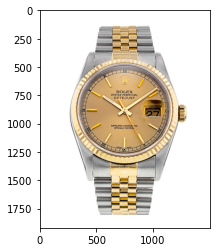

In [98]:
img_orig = cv2.imread(WATCH_DIR)[...,::-1]
imgplot = plt.imshow(img_orig)
print(f"Actual:\t\t{MODEL}\nPredicted:\t{model_list[np.argmax(prediction)]}")

In [83]:
correct = 0
n = 35

for i in range(n):
    MODEL = random.choice(model_list)
    MODEL_DIR = os.path.join(VALIDATION_DIR, MODEL)
    WATCHES = os.listdir(MODEL_DIR)
    WATCH = random.choice(WATCHES)
    WATCH_DIR = os.path.join(MODEL_DIR, WATCH)
    
    img = image.load_img(WATCH_DIR, target_size=(300, 300))
    x = image.img_to_array(img) / 255.
    x = np.expand_dims(x, axis=0)

    prediction = model.predict(x)
    
    if MODEL == model_list[np.argmax(prediction)]:
        correct += 1

print(round(100 * correct/n, 2))

97.14
